In [15]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
import sys
sys.path.append('clustering')
import os 

from utils import *

In [8]:
import pandas as pd

cluster_df = pd.read_parquet(os.path.join(get_data_dir(), '2010s', 'cluster_df.parquet'))
cluster_df

data_dir:  /home/lyuzhuoqi/projects/clustering/data


,Scopus_label,movMF_label,movMF_distance,x_val,y_val,kmeans_label,kmeans_distance,skm_label,skm_distance
VID,,,,,,,,,
202381698,Multidisciplinary,22,0.445886,-67.928200,15.572327,17,0.628846,20,0.444711
137773608,Multidisciplinary,22,0.590942,-68.405334,-55.633186,17,0.735654,20,0.559494
125754415,Multidisciplinary,22,0.574571,-68.448853,-55.613579,17,0.705024,20,0.550081
3880285,Multidisciplinary,23,0.618842,-68.407288,-55.634430,8,0.724859,17,0.610582
111155417,Chemistry,23,0.220853,-54.506985,-61.217068,11,0.495787,12,0.198758
...,...,...,...,...,...,...,...,...,...
2764485818,Medicine,21,0.268070,-28.969574,34.819569,18,0.542531,14,0.251015
83454320,Arts and Humanities,25,0.034777,78.609909,31.736822,13,0.251599,3,0.056642
16507453,Arts and Humanities,6,0.113656,89.206772,17.625090,13,0.307089,3,0.128660


In [9]:
from sklearn.metrics.pairwise import cosine_similarity
from scipy.optimize import linear_sum_assignment
import numpy as np

def match_labels_by_centroids(labels1, labels2, data):
    """
    使用聚类质心的余弦相似度匹配两组标签
    :param labels1: 第一组聚类标签
    :param labels2: 第二组聚类标签
    :param data: 样本数据，用于计算聚类中心
    """
    unique_labels1 = np.unique(labels1)
    unique_labels2 = np.unique(labels2)

    centroids1 = []
    centroids2 = []

    # 计算每个聚类的质心
    for label in unique_labels1:
        centroids1.append(data[labels1 == label].mean(axis=0))
    for label in unique_labels2:
        centroids2.append(data[labels2 == label].mean(axis=0))

    # 计算余弦相似度
    similarity_matrix = cosine_similarity(centroids1, centroids2)

    # 使用匈牙利算法匹配
    row_ind, col_ind = linear_sum_assignment(-similarity_matrix)  # 负号用于最大化匹配

    # 返回匹配关系
    mapping = {unique_labels1[row]: unique_labels2[col] for row, col in zip(row_ind, col_ind)}
    return mapping, similarity_matrix

/home/lyuzhuoqi/miniconda3/envs/p2v/lib/python3.11/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [17]:
import pickle

with open(os.path.join(get_data_dir(), "2010s", 'wv'), 'rb') as f:
    wv = pickle.load(f)
all_vectors = wv.get_normed_vectors()
all_VIDs = wv.index_to_key

valid_VIDs = cluster_df[cluster_df['Scopus_label']!='Multidisciplinary'].index.values
valid_vectors = all_vectors[[all_VIDs.index(VID) for VID in valid_VIDs]]

method = 'movMF'

cluster2scopus,  similarity_matrix = match_labels_by_centroids(cluster_df[cluster_df['Scopus_label']!='Multidisciplinary'][f'{method}_label'], 
                                                               cluster_df[cluster_df['Scopus_label']!='Multidisciplinary']['Scopus_label'], 
                                                               valid_vectors)
cluster2color = {k: Scopus2color[v] for k, v in cluster2scopus.items() if v in Scopus2color}
cluster2scopus

data_dir:  /home/lyuzhuoqi/projects/clustering/data


{0: 'Materials Science',
 1: 'Decision Sciences',
 2: 'Business, Management and Accounting',
 3: 'Engineering',
 4: 'Veterinary',
 5: 'Chemical Engineering',
 6: 'Earth and Planetary Sciences',
 7: 'Dentistry',
 8: 'Neuroscience',
 9: 'Physics and Astronomy',
 10: 'Health Professions',
 11: 'Psychology',
 12: 'Nursing',
 13: 'Agricultural and Biological Sciences',
 14: 'Computer Science',
 15: 'Medicine',
 16: 'Mathematics',
 17: 'Economics, Econometrics and Finance',
 18: 'Environmental Science',
 19: 'Energy',
 20: 'Pharmacology, Toxicology and Pharmaceutics',
 21: 'Immunology and Microbiology',
 22: 'Biochemistry, Genetics and Molecular Biology',
 23: 'Chemistry',
 24: 'Social Sciences',
 25: 'Arts and Humanities'}

In [39]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

top_n = 3  # 每个聚类提取前 n 个关键词

# 自定义词映射
word_mapping = {'mechanics': 'mechanic',
                'mechanical': 'mechanic',
                'electrical': 'electric',
                'electronics': 'electric',
                'financial': 'finance',
                'political': 'politics',
                'historical': 'history',
                'computer': 'computing',
                'intelligent': 'intelligence',
                'agricultural': 'agriculture',
                'educational': 'education',
                'dental': 'dentistry',
                'archaeological': 'archaeology',
                'mathematical': 'mathematics',
                'mathematica': 'mathematics',
                'matematico': 'mathematics',
                'mathematicae': 'mathematics',
                'economic': 'economics',
                'chemical': 'chemistry',
                'geophysical': 'geophysics',
                'botanical': 'botany',
                'physical': 'physics',
                'entomological': 'entomology', 
                'entomologist': 'entomology',
                'biological': 'biology',
                'geographical': 'geography',
                'geological': 'geology',
                'geographer': 'geography',
                'medical': 'medicine',
}
cluster_df = pd.read_parquet(os.path.join(get_data_dir(), '2010s', 'cluster_df.parquet'))
venue_df = pd.read_parquet(os.path.join(get_data_dir(),"MAG_venue.parquet"))
cluster_df = pd.merge(cluster_df, venue_df['OriginalVenue'],
                      right_index=True, left_index=True)

# 定义预处理函数，进行自定义词映射
def preprocess_text(text):
    words = text.lower().split()  # 将文本小写并按空格分词
    mapped_words = [word_mapping[word] if word in word_mapping else word for word in words]
    filtered_words = [word for word in mapped_words if word not in periodical_title_stopwords]
    return ' '.join(filtered_words)

# 按 cluster_label 分组，将 OriginalVenue 文本合并为一个文档，并进行预处理
cluster_docs = (
    cluster_df.groupby(f'{method}_label')['OriginalVenue']
    .apply(lambda x: preprocess_text(' '.join(x)))
    .tolist()
)

# 计算 TF-IDF
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(cluster_docs)

# 获取每个聚类中最重要的关键词
top_words = {}
feature_names = vectorizer.get_feature_names_out()

# 确保 cluster_label 的顺序与 cluster_docs 一致
cluster_labels = sorted(cluster_df[f'{method}_label'].unique())

for j, cluster_label in enumerate(cluster_labels):
    tfidf_scores = tfidf_matrix[j].toarray().flatten()
    top_indices = tfidf_scores.argsort()[-top_n:][::-1]  # 获取前 n 个关键词的索引
    top_words[cluster_label] = [feature_names[idx] for idx in top_indices]

top_words

data_dir:  /home/lyuzhuoqi/projects/clustering/data
data_dir:  /home/lyuzhuoqi/projects/clustering/data


{0: ['engineering', 'mechanic', 'technology'],
 1: ['intelligence', 'computing', 'systems'],
 2: ['management', 'business', 'marketing'],
 3: ['electric', 'ieee', 'systems'],
 4: ['veterinary', 'animal', 'veterinaria'],
 5: ['plant', 'food', 'agriculture'],
 6: ['archaeology', 'history', 'medieval'],
 7: ['dentistry', 'oral', 'maxillofacial'],
 8: ['neurology', 'neuroscience', 'clinical'],
 9: ['laser', 'engineering', 'optics'],
 10: ['sports', 'medicine', 'rehabilitation'],
 11: ['education', 'learning', 'teaching'],
 12: ['health', 'psychology', 'nursing'],
 13: ['ecology', 'entomology', 'biology'],
 14: ['computing', 'acm', 'systems'],
 15: ['medicine', 'clinical', 'cardiovascular'],
 16: ['mathematics', 'analysis', 'algebra'],
 17: ['economics', 'finance', 'policy'],
 18: ['geology', 'earth', 'water'],
 19: ['politics', 'law', 'social'],
 20: ['oncology', 'surgery', 'cancer'],
 21: ['medicine', 'health', 'infectious'],
 22: ['cell', 'molecular', 'biology'],
 23: ['chemistry', 'mate

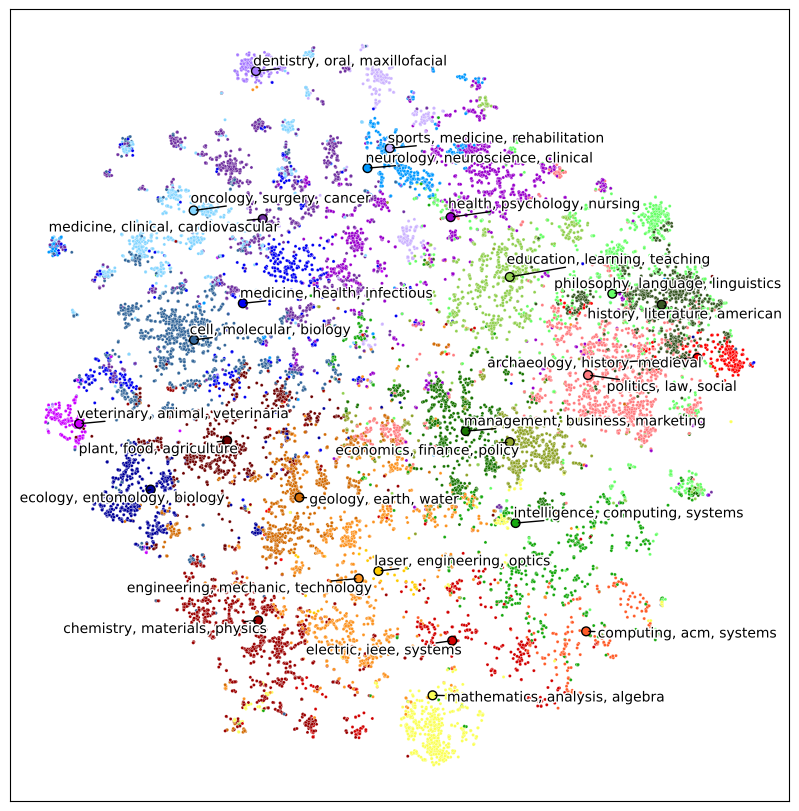

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
import adjustText
import matplotlib.patheffects as path_effects

fig = plt.figure(figsize=(8,8), layout='constrained')
ax = plt.gca()
ax.set_aspect('equal')

scatter = sns.scatterplot(data=cluster_df, x='x_val', y='y_val', 
                          hue=f'{method}_label', palette=cluster2color, s=5, alpha=1,
                          ax=ax)
# Calculate the center points for each cluster
centers = cluster_df.groupby(f'{method}_label')[['x_val', 'y_val']].mean().reset_index()
# Annotate the center points with top words
texts = []
for _, row in centers.iterrows():
    cluster_label = row[f'{method}_label']
    words = top_words[cluster_label]
    text = ax.text(row['x_val'], row['y_val'], ', '.join(words), fontsize=10, ha='center', va='center') 
    text.set_path_effects([path_effects.Stroke(linewidth=2, foreground='white'), path_effects.Normal()])
    texts.append(text)

# Plot the center points
sns.scatterplot(data=centers, x='x_val', y='y_val', hue=f'{method}_label', palette=cluster2color, s=40, marker='o',
                edgecolor='k', linewidth=1, ax=ax, legend=False)
ax.legend().set_visible(False)
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_xticks([])
ax.set_yticks([])

adjustText.adjust_text(texts, arrowprops=dict(arrowstyle='-', color='black'))
plt.show()